# Comparison of all perturbations
Use extracted features to build per-cell representations and analyse similarity of perturbations with them
- plot UMAP
- calculate distance of perturbartions 

In [15]:
from miann.constants import EXPERIMENT_DIR
from miann.data import MPPData
from miann.tl import Experiment
from miann.tl import Cluster, FeatureExtractor
from miann.tl._cluster import add_clustering_to_adata
from miann.pl import annotate_img
from miann.utils import init_logging
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import squidpy as sq
from sklearn.metrics import silhouette_score
import json
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

In [77]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (0.5h)'
    p[p == 'CX5461-120'] = 'CX5461 (2h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12h)'
    p[p == 'TSA-30'] = 'TSA (0.5h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')
    adata.uns['perturbation_plot_colors'] = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']  #https://gist.github.com/thriveth/8560036

In [3]:
os.makedirs('fig3', exist_ok=True)
#os.makedirs('fig1_suppl', exist_ok=True)

In [4]:
from numba import jit, njit
#from scipy.spatial.distance import cityblock

@njit
def cityblock(a,b,w=None):
    if w is None:
        w = np.ones_like(a)
    return np.mean(np.abs(a-b)*w)

def calc_co_occ_knn(adata, cluster_pairs=None, key_added='co_occurrence'):
    """
    Calculate knn graph using co_occurrence scores.

    Args:
        adata: concatenated feature adata containing co_occurrence scores in adata.obsm
        cluster_pairs: list of cluster tuples that should be used to calculate neighborhood graph. 
            If none, all available cluster pairs are used

    adds 
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if cluster_pairs is None:
        cluster_pairs = [(c1, c2) for c1 in adata.uns['clusters'] for c2 in adata.uns['clusters']]
    co_occ_keys = [f'co_occurrence_{c1}_{c2}' for c1, c2 in cluster_pairs]

    # build combined co-occ matrix
    arr = np.concatenate([adata.obsm[k] for k in co_occ_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr

    # weights to use for l1 distance
    distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, metric_kwds={'w': np.tile(distances/np.mean(distances), len(cluster_pairs))}, key_added=key_added)

def calc_intensity_knn(adata, clusters=None, key_added='intensity'):
    """
    Calculate knn graph using mean cluster intensity.

    Args:
        adata: concatenated feature adata containing intensity scores in adata.obsm
        clusters: list of cluster names that should be used to calculate neighborhood graph.
            If none, all available cluster pairs are used.

    adds
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if clusters is None:
        clusters = adata.uns['clusters']
    intensity_keys = [f'intensity_{c}' for c in clusters]
    
    # build combined intensity matrix
    arr = np.concatenate([adata.layers[k] for k in intensity_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, key_added=key_added)

## Load data

In [5]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

# get combined adata
adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata)

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

## Calculate knn based on intensity and co-occ scores

In [7]:
calc_co_occ_knn(adata, key_added='co_occurrence')
adata.obsm['X_co_occurrence_umap'] = sc.tl.umap(adata, min_dist=0.05, spread=2, neighbors_key='co_occurrence', copy=True).obsm['X_umap']

In [8]:
calc_intensity_knn(adata, key_added='intensity')
adata.obsm['X_intensity_umap'] = sc.tl.umap(adata, neighbors_key='intensity', copy=True).obsm['X_umap']

In [9]:
# mean intensity knn with X
sc.pp.neighbors(adata, metric=cityblock, key_added='mpp')
adata.obsm['X_mpp_umap'] = sc.tl.umap(adata, neighbors_key='mpp', copy=True).obsm['X_umap']

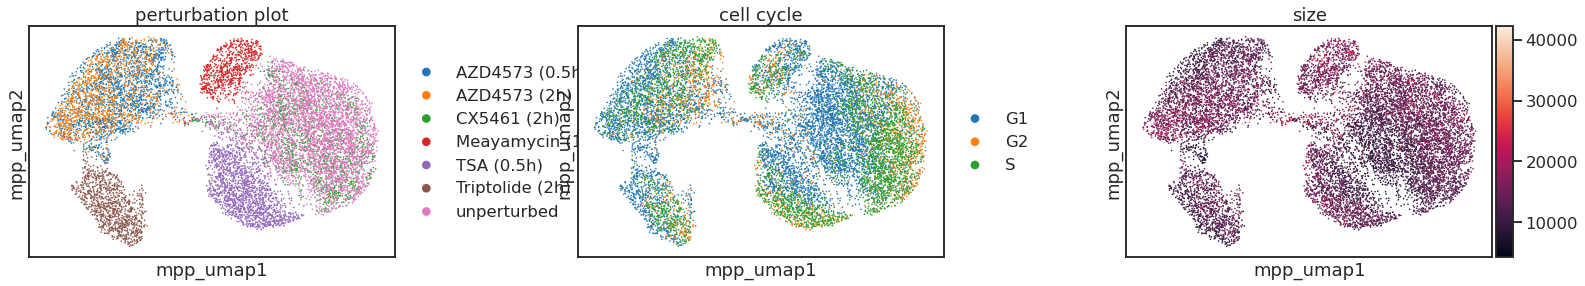

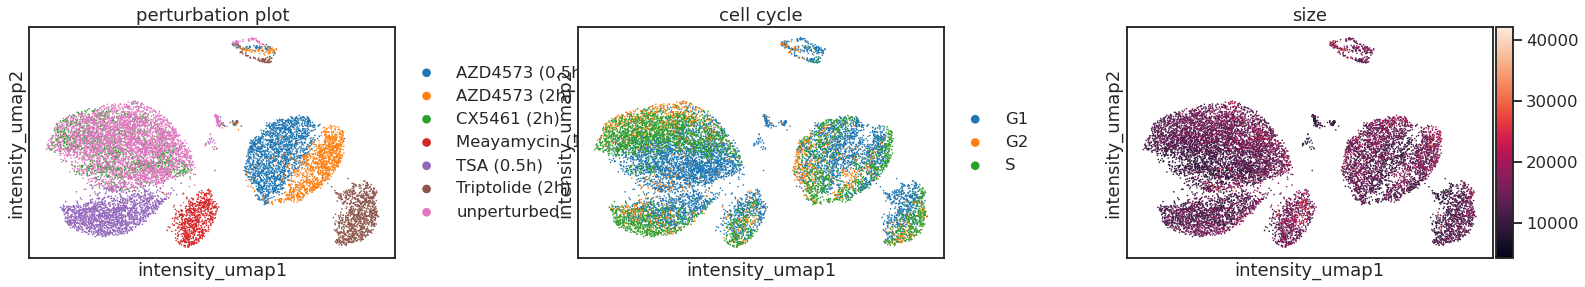

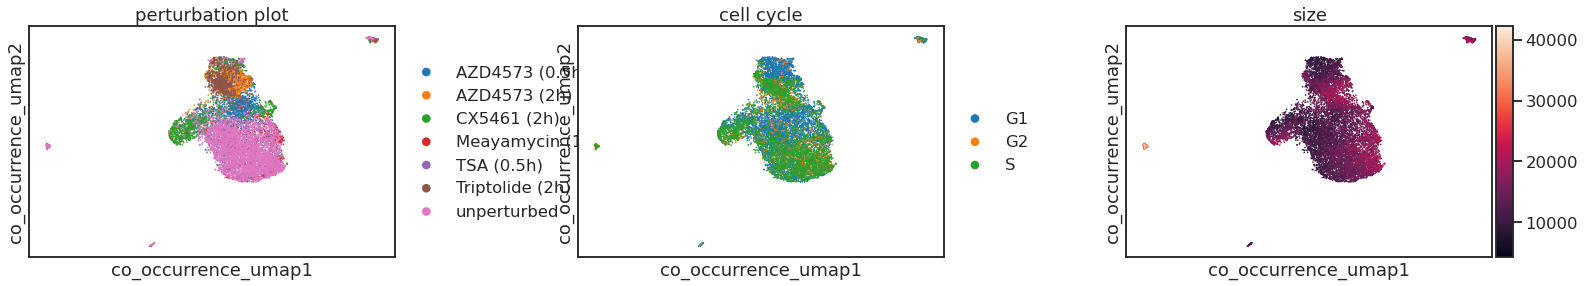

In [66]:
adata.obs['size'] = adata.obsm['size']['all']
sc.pl.scatter(adata, basis='mpp_umap', color=['perturbation_plot', 'cell_cycle', 'size'])
sc.pl.scatter(adata, basis='intensity_umap', color=['perturbation_plot', 'cell_cycle', 'size'])
sc.pl.scatter(adata, basis='co_occurrence_umap', color=['perturbation_plot', 'cell_cycle', 'size'])

In [83]:
def catplot(basis, color, axlabel, save=None):
    fig, ax = plt.subplots(1,1)
    sc.pl.scatter(adata, basis=basis, color=color, ax=ax, show=False)
    ax.set_xlabel(f'{axlabel}1')
    ax.set_ylabel(f'{axlabel}2')
    if save is not None:
        plt.savefig(os.path.join('fig3', save), dpi=100, bbox_inches='tight')
    

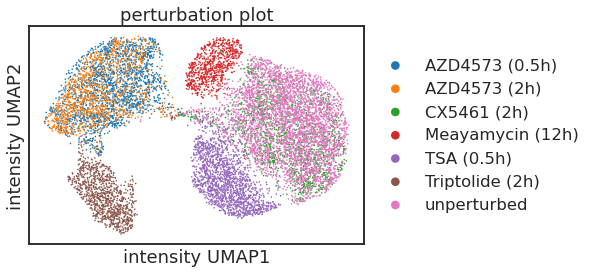

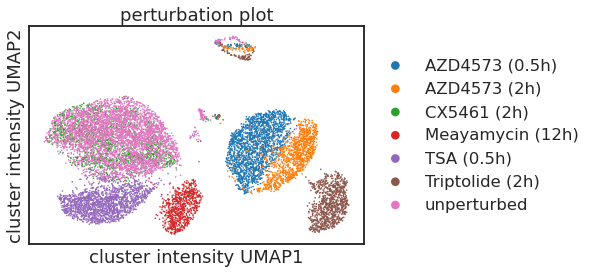

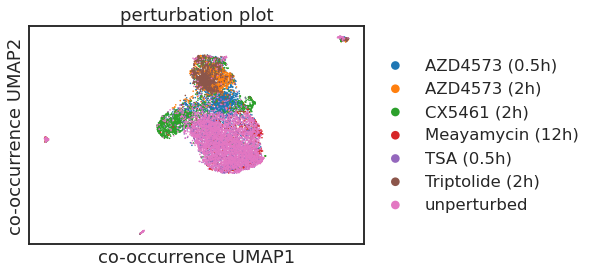

In [84]:
# final UMAP figure
sns.set_style('white')
sns.set_context('talk')

catplot('mpp_umap', 'perturbation_plot', 'intensity UMAP', save='intensity_umap.png')
catplot('intensity_umap', 'perturbation_plot', 'cluster intensity UMAP', save='cluster_intensity_umap.png')
catplot('co_occurrence_umap', 'perturbation_plot', 'co-occurrence UMAP', save='co_occ_umap.png')


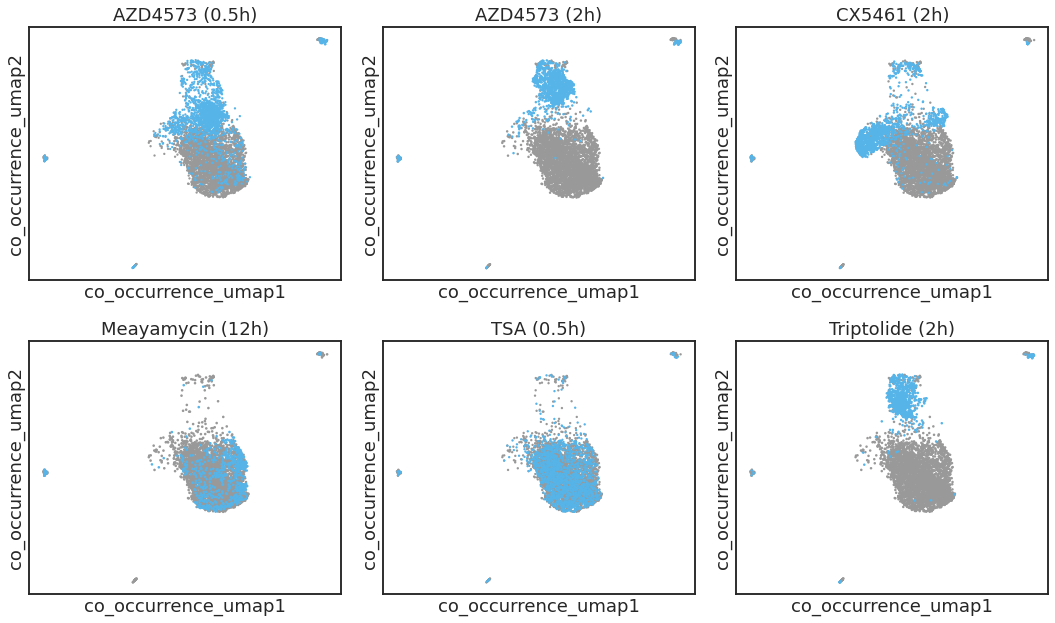

In [89]:
# maybe suppl figure
fig, axes = plt.subplots(2,3, figsize=(15,9))
i = 0
for p in adata.obs['perturbation_plot'].cat.categories:
    if p == 'unperturbed':
        continue
    ax = axes.flat[i]
    i += 1
    tmp = adata[adata.obs['perturbation_plot'].isin(['unperturbed', p])]
    tmp.obs[p] = (tmp.obs['perturbation_plot'] == p).astype('category')
    tmp.uns[f'{p}_colors'] = ["#999999", "#56B4E9"]
    
    sc.pl.scatter(tmp, color=p, basis='co_occurrence_umap', ax=ax, show=False, legend_loc='none')
plt.tight_layout()
plt.savefig('fig3/co_occ_umap_suppl.png', dpi=100, bbox_inches='tight')

## Calculate pairwise similarity between perturbations

### neighborhood enrichment

In [10]:
# calculate neighbohood enrichment
zscore_co_occ, count_co_occ = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                     connectivity_key='co_occurrence', n_perms=1000, 
                                                     numba_parallel=False, copy=True)
zscore_intensity, count_intensity = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                           connectivity_key='intensity', n_perms=1900, 
                                                           numba_parallel=False, copy=True)

100%|██████████| 1900/1900 [00:01<00:00, 1150.29/s]


In [12]:
zscore_mpp, count_mpp = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                               connectivity_key='mpp', n_perms=1900, 
                                               numba_parallel=False, copy=True)

100%|██████████| 1900/1900 [00:01<00:00, 1154.13/s]


### silhouette score

In [13]:
# calculate silhouette score
from sklearn.metrics import silhouette_score

cond_key = 'perturbation_plot'

# co-occurrence
siscore_co_occ = np.zeros([len(adata.obs[cond_key].cat.categories)]*2)
distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
distances = np.tile(distances/np.mean(distances), int(adata.obsm['co_occurrence'].shape[1] / len(distances))).astype(np.float64)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        print(i,j)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        siscore_co_occ[i,j] = silhouette_score(adata_sub.obsm['co_occurrence'], labels=adata_sub.obs[cond_key], metric=cityblock, w=distances)
        siscore_co_occ[j,i] = siscore_co_occ[i,j]

# intensity
siscore_intensity = np.zeros([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        #print(i,j)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        siscore_intensity[i,j] = silhouette_score(adata_sub.obsm['intensity'], labels=adata_sub.obs[cond_key], metric=cityblock)
        siscore_intensity[j,i] = siscore_intensity[i,j]

0 1


KeyboardInterrupt: 

In [53]:
# intensity
siscore_mpp = np.zeros([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        #print(i,j)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        siscore_mpp[i,j] = silhouette_score(adata_sub.X, labels=adata_sub.obs[cond_key], metric=cityblock)
        siscore_mpp[j,i] = siscore_mpp[i,j]

In [149]:
# save siscores
pickle.dump([siscore_mpp, siscore_intensity, siscore_co_occ], open('fig3/siscores.pickle', 'wb'))


In [16]:
siscore_mpp, siscore_intensity, siscore_co_occ = pickle.load(open('fig3/siscores.pickle', 'rb'))

### logistic regression - balanced acc

In [17]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def get_prediction_scores(X, y, measure='acc', n_val=10000, class_weights=None):
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    np.random.seed(0)
    scores = []
    # 10 times with different score
    for i in range(10):
        mask = np.full(len(y), False)
        mask[:n_val] = True
        np.random.shuffle(mask)
        clf = LogisticRegression().fit(scaled_X[~mask] , y[~mask])
        #print(len(scaled_X[mask]))
        ypred = clf.predict(scaled_X[mask])
        if measure == 'acc':
            weights = None
            if class_weights is not None:
                weights = class_weights[y[mask].astype(int)]
            score = accuracy_score(y[mask], ypred, sample_weight=weights)
        elif measure == 'balanced_acc':
            score = balanced_accuracy_score(y[mask], ypred)
        scores.append(score)
    return scores

In [18]:
cond_key = 'perturbation_plot'

# classification from MPP
acc_mpp = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.X)
        acc_mpp[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_mpp[j,i] = acc_mpp[i,j]
        
# classification from co-occ
acc_co_occ = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.obsm['co_occurrence'])
        acc_co_occ[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_co_occ[j,i] = acc_co_occ[i,j]

# classification from intensity
acc_intensity = np.ones([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    print(i)
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        y = adata_sub.obs[cond_key] == c1
        X = PCA(n_components=10).fit_transform(adata_sub.obsm['intensity'])
        acc_intensity[i,j] = np.mean(get_prediction_scores(X, y, n_val=int(len(y)*0.1), measure='balanced_acc'))
        acc_intensity[j,i] = acc_intensity[i,j]

0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


## Plot pairwise similarities

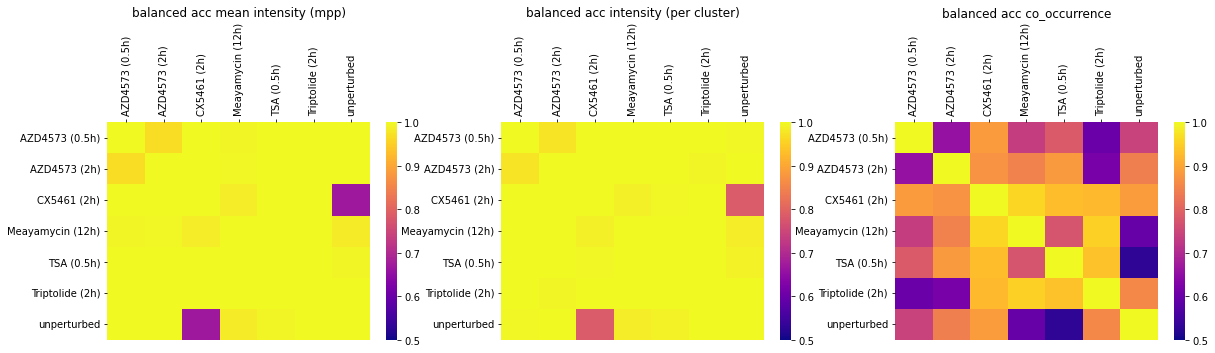

In [20]:
# plot acc scores
fig, axes = plt.subplots(1,3, figsize=(20,4))

sns.heatmap(acc_mpp, vmin=0.5, vmax=1, cmap='plasma', ax=axes[0])
axes[0].set_title('balanced acc mean intensity (mpp)')

sns.heatmap(acc_intensity, vmin=0.5, vmax=1, cmap='plasma', ax=axes[1])
axes[1].set_title('balanced acc intensity (per cluster)')

sns.heatmap(acc_co_occ, vmin=0.5, vmax=1, cmap='plasma', ax=axes[2])
axes[2].set_title('balanced acc co_occurrence')

for ax in axes.flat:
    ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
    ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
    ax.xaxis.set_ticks_position('top')
    

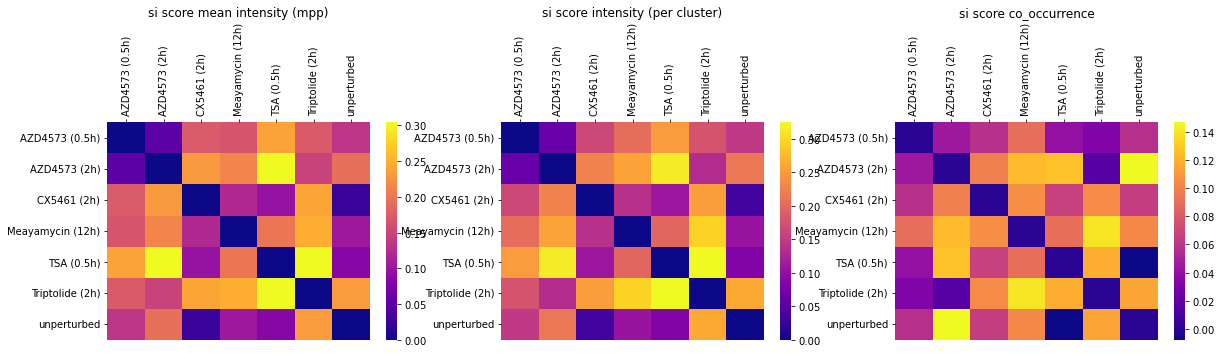

In [21]:
# plot silhouette scores
fig, axes = plt.subplots(1,3, figsize=(20,4))

sns.heatmap(siscore_mpp, vmin=None, vmax=None, cmap='plasma', ax=axes[0])
axes[0].set_title('si score mean intensity (mpp)')

sns.heatmap(siscore_intensity, vmin=None, vmax=None, cmap='plasma', ax=axes[1])
axes[1].set_title('si score intensity (per cluster)')

sns.heatmap(siscore_co_occ, vmin=None, vmax=None, cmap='plasma', ax=axes[2])
axes[2].set_title('si score co_occurrence')

for ax in axes.flat:
    ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
    ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
    ax.xaxis.set_ticks_position('top')

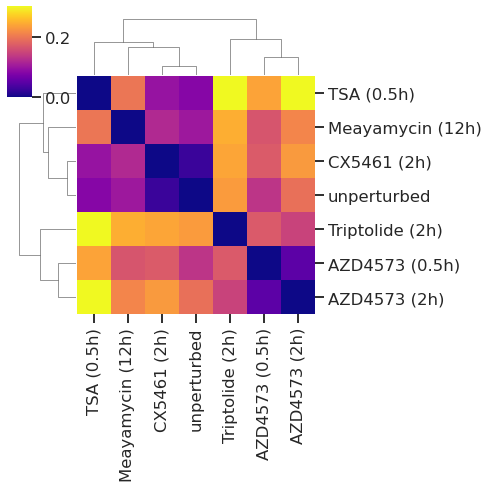

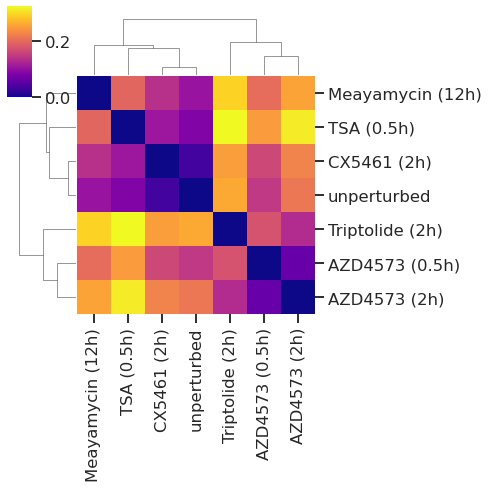

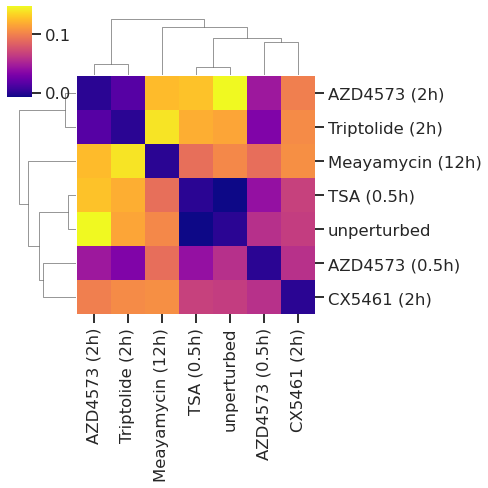

In [92]:
# plot si scores
sns.set_style('ticks')
sns.set_context('talk')
# intensity
g = sns.clustermap(siscore_mpp, vmin=None, vmax=None, cmap='plasma', yticklabels=adata.obs['perturbation_plot'].cat.categories,
              xticklabels=adata.obs['perturbation_plot'].cat.categories, figsize=(7,7))
plt.savefig('fig3/intensity_siscore.png')

# cluster intensity
g = sns.clustermap(siscore_intensity, vmin=None, vmax=None, cmap='plasma', yticklabels=adata.obs['perturbation_plot'].cat.categories,
              xticklabels=adata.obs['perturbation_plot'].cat.categories, figsize=(7,7))
plt.savefig('fig3/cluster_intensity_siscore.png')

# co occurrence
g = sns.clustermap(siscore_co_occ, vmin=None, vmax=None, cmap='plasma', yticklabels=adata.obs['perturbation_plot'].cat.categories,
              xticklabels=adata.obs['perturbation_plot'].cat.categories, figsize=(7,7))
plt.savefig('fig3/co_occ_siscore.png')


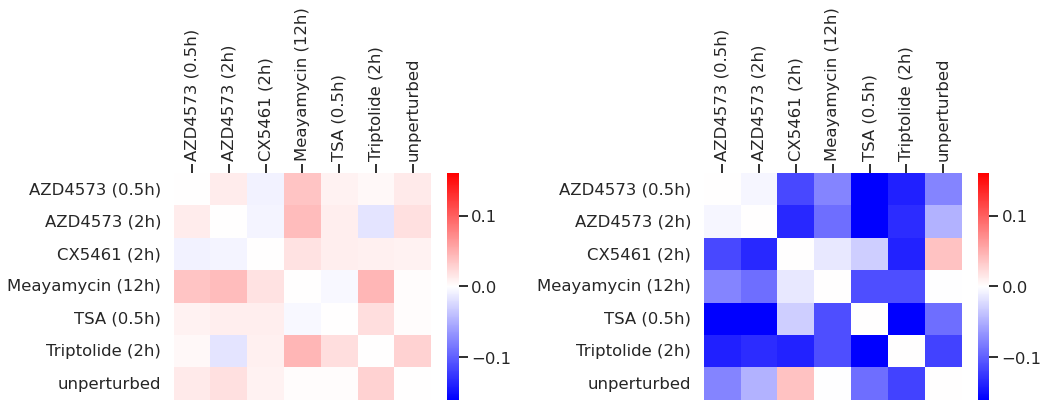

In [93]:
# plot silhouette scores
sns.set_style('white')
sns.set_context('talk')

fig, axes = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(siscore_intensity - siscore_mpp, vmin=-0.16, vmax=0.16, cmap='bwr', ax=axes[0])
#axes[0].set_title('change in silhouette score with per cluster intensity')

sns.heatmap(siscore_co_occ - siscore_mpp, vmin=-0.16, vmax=0.16, cmap='bwr', ax=axes[1])
#axes[1].set_title('change in silhouette score with co-occurrence score')


for ax in axes.flat:
    ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
    ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
    ax.xaxis.set_ticks_position('top')
    
plt.tight_layout()
plt.savefig('fig3/siscore_difference.png')

### other plots

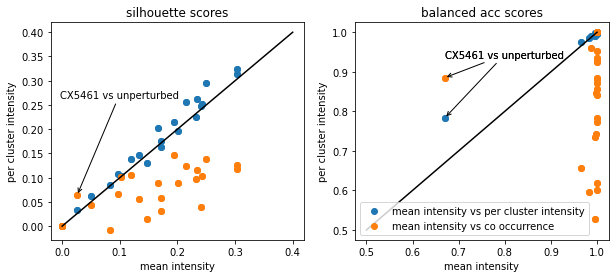

In [142]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].scatter(siscore_mpp.flat, siscore_intensity.flat, label='mean intensity vs per cluster intensity')
axes[0].scatter(siscore_mpp.flat, siscore_co_occ.flat, label='mean intensity vs co occurrence')
axes[0].plot([0,0.4],[0,0.4], c='black')
axes[0].set_xlabel('mean intensity')
axes[0].set_ylabel('per cluster intensity')
axes[0].set_title('silhouette scores')

coord = np.array([siscore_mpp[2,6], siscore_co_occ[2,6]])
axes[0].annotate(text='CX5461 vs unperturbed',
            xy=coord,
            xycoords='data',
            fontsize=10,
            xytext=coord+[-0.03,0.2],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))   # New param


axes[1].scatter(acc_mpp.flat, acc_intensity.flat, label='mean intensity vs per cluster intensity')
axes[1].scatter(acc_mpp.flat, acc_co_occ.flat, label='mean intensity vs co occurrence')
axes[1].plot([0.5,1],[0.5,1], c='black')
axes[1].set_xlabel('mean intensity')
axes[1].set_ylabel('per cluster intensity')
axes[1].set_title('balanced acc scores')

coord = np.array([acc_mpp[2,6], acc_co_occ[2,6]])
axes[1].annotate(text='CX5461 vs unperturbed',
            xy=coord,
            xycoords='data',
            fontsize=10,
            xytext=coord+[0.0,0.05],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))
coord1 = np.array([acc_mpp[2,6], acc_intensity[2,6]])
axes[1].annotate(text='CX5461 vs unperturbed',
            xy=coord1,
            xycoords='data',
            fontsize=10,
            xytext=coord+[0.0,0.05],
            textcoords='data',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.legend()

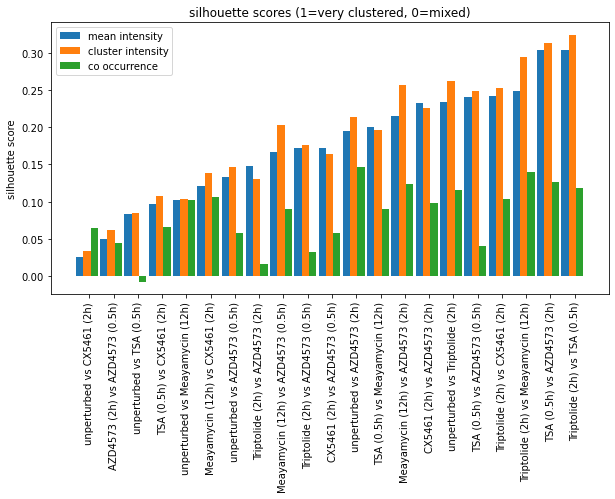

In [146]:
labels = []
sel_mpp = []
sel_intensity = []
sel_co_occ = [] 
for i in range(len(siscore_mpp)):
    for j in range(len(siscore_mpp)):
        if j >= i:
            continue
        labels.append('{} vs {}'.format(adata.obs['perturbation_plot'].cat.categories[i], adata.obs['perturbation_plot'].cat.categories[j])) 
        sel_mpp.append(siscore_mpp[i,j])
        sel_intensity.append(siscore_intensity[i,j])
        sel_co_occ.append(siscore_co_occ[i,j])
# sort lists by mpp scores
sel_intensity = [x for _,x in sorted(zip(sel_mpp, sel_intensity))]
sel_co_occ = [x for _,x in sorted(zip(sel_mpp, sel_co_occ))]
labels = [x for _,x in sorted(zip(sel_mpp, labels))]
sel_mpp = sorted(sel_mpp)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(x=np.array(range(len(labels)))+0.1, height=sel_mpp, width=0.3, label='mean intensity')
ax.bar(x=np.array(range(len(labels)))+0.4, height=sel_intensity, width=0.3, label='cluster intensity')
ax.bar(x=np.array(range(len(labels)))+0.7, height=sel_co_occ, width=0.3, label='co occurrence')

ax.set_ylabel('silhouette score')
ax.set_xticks(np.array(range(len(labels)))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('silhouette scores (1=very clustered, 0=mixed)')
plt.legend()

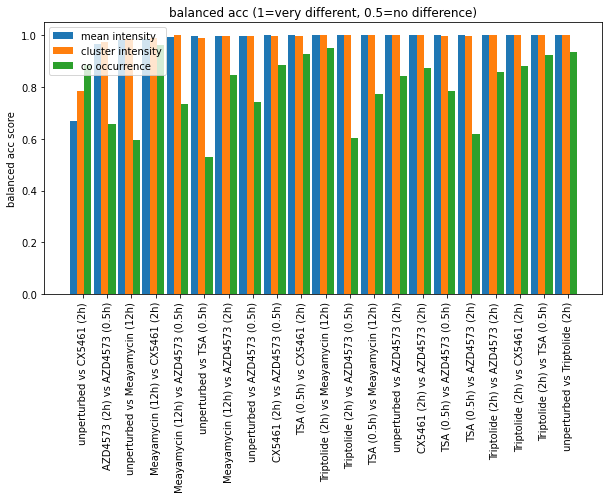

In [148]:
labels = []
sel_mpp = []
sel_intensity = []
sel_co_occ = [] 
for i in range(len(acc_mpp)):
    for j in range(len(acc_mpp)):
        if j >= i:
            continue
        labels.append('{} vs {}'.format(adata.obs['perturbation_plot'].cat.categories[i], adata.obs['perturbation_plot'].cat.categories[j])) 
        sel_mpp.append(acc_mpp[i,j])
        sel_intensity.append(acc_intensity[i,j])
        sel_co_occ.append(acc_co_occ[i,j])
# sort lists by mpp scores
sel_intensity = [x for _,x in sorted(zip(sel_mpp, sel_intensity))]
sel_co_occ = [x for _,x in sorted(zip(sel_mpp, sel_co_occ))]
labels = [x for _,x in sorted(zip(sel_mpp, labels))]
sel_mpp = sorted(sel_mpp)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(x=np.array(range(len(labels)))+0.1, height=sel_mpp, width=0.3, label='mean intensity')
ax.bar(x=np.array(range(len(labels)))+0.4, height=sel_intensity, width=0.3, label='cluster intensity')
ax.bar(x=np.array(range(len(labels)))+0.7, height=sel_co_occ, width=0.3, label='co occurrence')

ax.set_ylabel('balanced acc score')
ax.set_xticks(np.array(range(len(labels)))+0.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('balanced acc (1=very different, 0.5=no difference)')
plt.legend()